# Struttura dei test

Per la fase di test sono stati generati dei dataset tramite la funzione
`make_classification` del modulo `scikit-learn`. Ogni dataset ha un totale di
100 punti, 90 dei quali sono stati utilizzati per il training dei modelli. Ne
segue che l'algoritmo genetico è stato eseguito su un totale di 10 punti per
dataset. I parametri che variano da un dataset all'altro sono:

- **Numero di feature di ogni punto**: 2, 4, 8, 16, 32.
- **Numero di classi possibili per ogni punto**: 2.
- **Numero di cluster per ogni classe**: 1, 2.
- **Seme di casualità per il generatore**: 0, 1, 2, 3, 4.

Per i test effettuati sono stati presi in considerazione tre modelli differenti
del modulo `scikit-learn`: `RandomForestClassifier`, `SVC` e `MLPClassifier`.
Su ognuno dei dataset è stato eseguito l'algoritmo genetico usando tutti e tre
i modelli e, per ognuno di essi, popolazioni sintetiche da 1000, 2000 e 4000
individui.

## Dataset dei risultati

Ogni riga del dataset contiene:

- **Informazioni sul dataset**:
  - **samples**: numero di punti, per ciascun dataset, su cui è stato eseguito
    l'algoritmo genetico.
  - **features**: numero di feature dei punti nel dataset.
  - **classes**: numero di classi possibili per un determinato dataset.
  - **clusters**: numero di cluster per classe.
  - **seed**: seme di casualità con cui è stato generato il dataset.
- **Parametri algoritmo genetico**:
  - **population_size**: numero di individui sintetici.
  - **point**: punto del dataset da cui vengono generati gli altri punti.
  - **class**: classe del punto.
  - **target**: classe target dell'algoritmo genetico.
  - **model**: il modello utilizzato per la classificazione.
- **Risultati**:
  - **min/mean/max_fitness**: valori minimo, medio e massimo di fitness, della
    popolazione generata dall'algoritmo genetico.
  - **fitness_std**: deviazione standard dei valori di fitness della popolazione
    sintetica finale.
  - **accuracy**: valore di _precisione_ dell'algoritmo genetico. Si tratta
    della percentuale di individui sintetici classificati nella classe target.

Possiamo quindi vedere ogni riga come una singola esecuzione dell'algoritmo
genetico su uno specifico punto, di uno specifico dataset e con una specifica
classe target.


In [5]:
import pandas as pd

rf = pd.read_csv("../results/neighborhood_RandomForestClassifier.csv")
svm = pd.read_csv("../results/neighborhood_SVC.csv")
mlp = pd.read_csv("../results/neighborhood_MLPClassifier.csv")
df = pd.concat([rf, svm, mlp], axis=0)

### Conversione fitness-distanza

Dato che i valori di fitness non sono altro che la distanza di ogni punto
sintetico dal punto preso in esame, moltiplicata per un peso di $-1$, possiamo
convertire le tre colonne di fitness in valori di distanza rimoltiplicandole
per $-1$ di modo da avere valori meglio interpretabili.

Ovviamente ciò che era considerato un valori di fitness minimo, diventerà
un valore di distanza massimo (stesso discorso per i valori di fitness massimi).


In [6]:
df[["min_fitness", "mean_fitness", "max_fitness"]] *= -1.0
df = df.rename(
    columns={
        "min_fitness": "max_distance",
        "mean_fitness": "mean_distance",
        "fitness_std": "distance_std",
        "max_fitness": "min_distance",
    }
)

df

,samples,features,classes,clusters,seed,population_size,point,class,target,model,max_distance,mean_distance,distance_std,min_distance,accuracy
0,10,4,2,1,0,1000,0,1,0,RandomForestClassifier,2.435582,1.661742,0.729705,0.325748,1.0
1,10,4,2,1,0,1000,0,1,1,RandomForestClassifier,0.529250,0.298525,0.143279,0.000396,1.0
2,10,4,2,1,0,1000,1,1,0,RandomForestClassifier,1.755410,1.592907,0.095327,1.403512,1.0
3,10,4,2,1,0,1000,1,1,1,RandomForestClassifier,0.566683,0.318188,0.157992,0.001270,1.0
4,10,4,2,1,0,1000,2,0,0,RandomForestClassifier,0.925029,0.510027,0.268391,0.001007,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,10,8,2,2,4,4000,7,1,1,MLPClassifier,1.256150,0.581352,0.368271,0.000229,1.0
2996,10,8,2,2,4,4000,8,1,0,MLPClassifier,1.857684,1.762059,0.056239,1.615817,1.0
2997,10,8,2,2,4,4000,8,1,1,MLPClassifier,0.962032,0.435857,0.281996,0.000398,1.0
2998,10,8,2,2,4,4000,9,0,0,MLPClassifier,1.114518,0.499753,0.320833,0.004312,1.0


# Analisi

Procediamo analizzando i risultati mettendo il focus su un paio di parametri
alla volta. Per ogni classificatore verrano svolte analisi separate.

Iniziamo con il valutare i risultati ottenuti dai diversi modelli con un
diverso numero di individui sintetici.


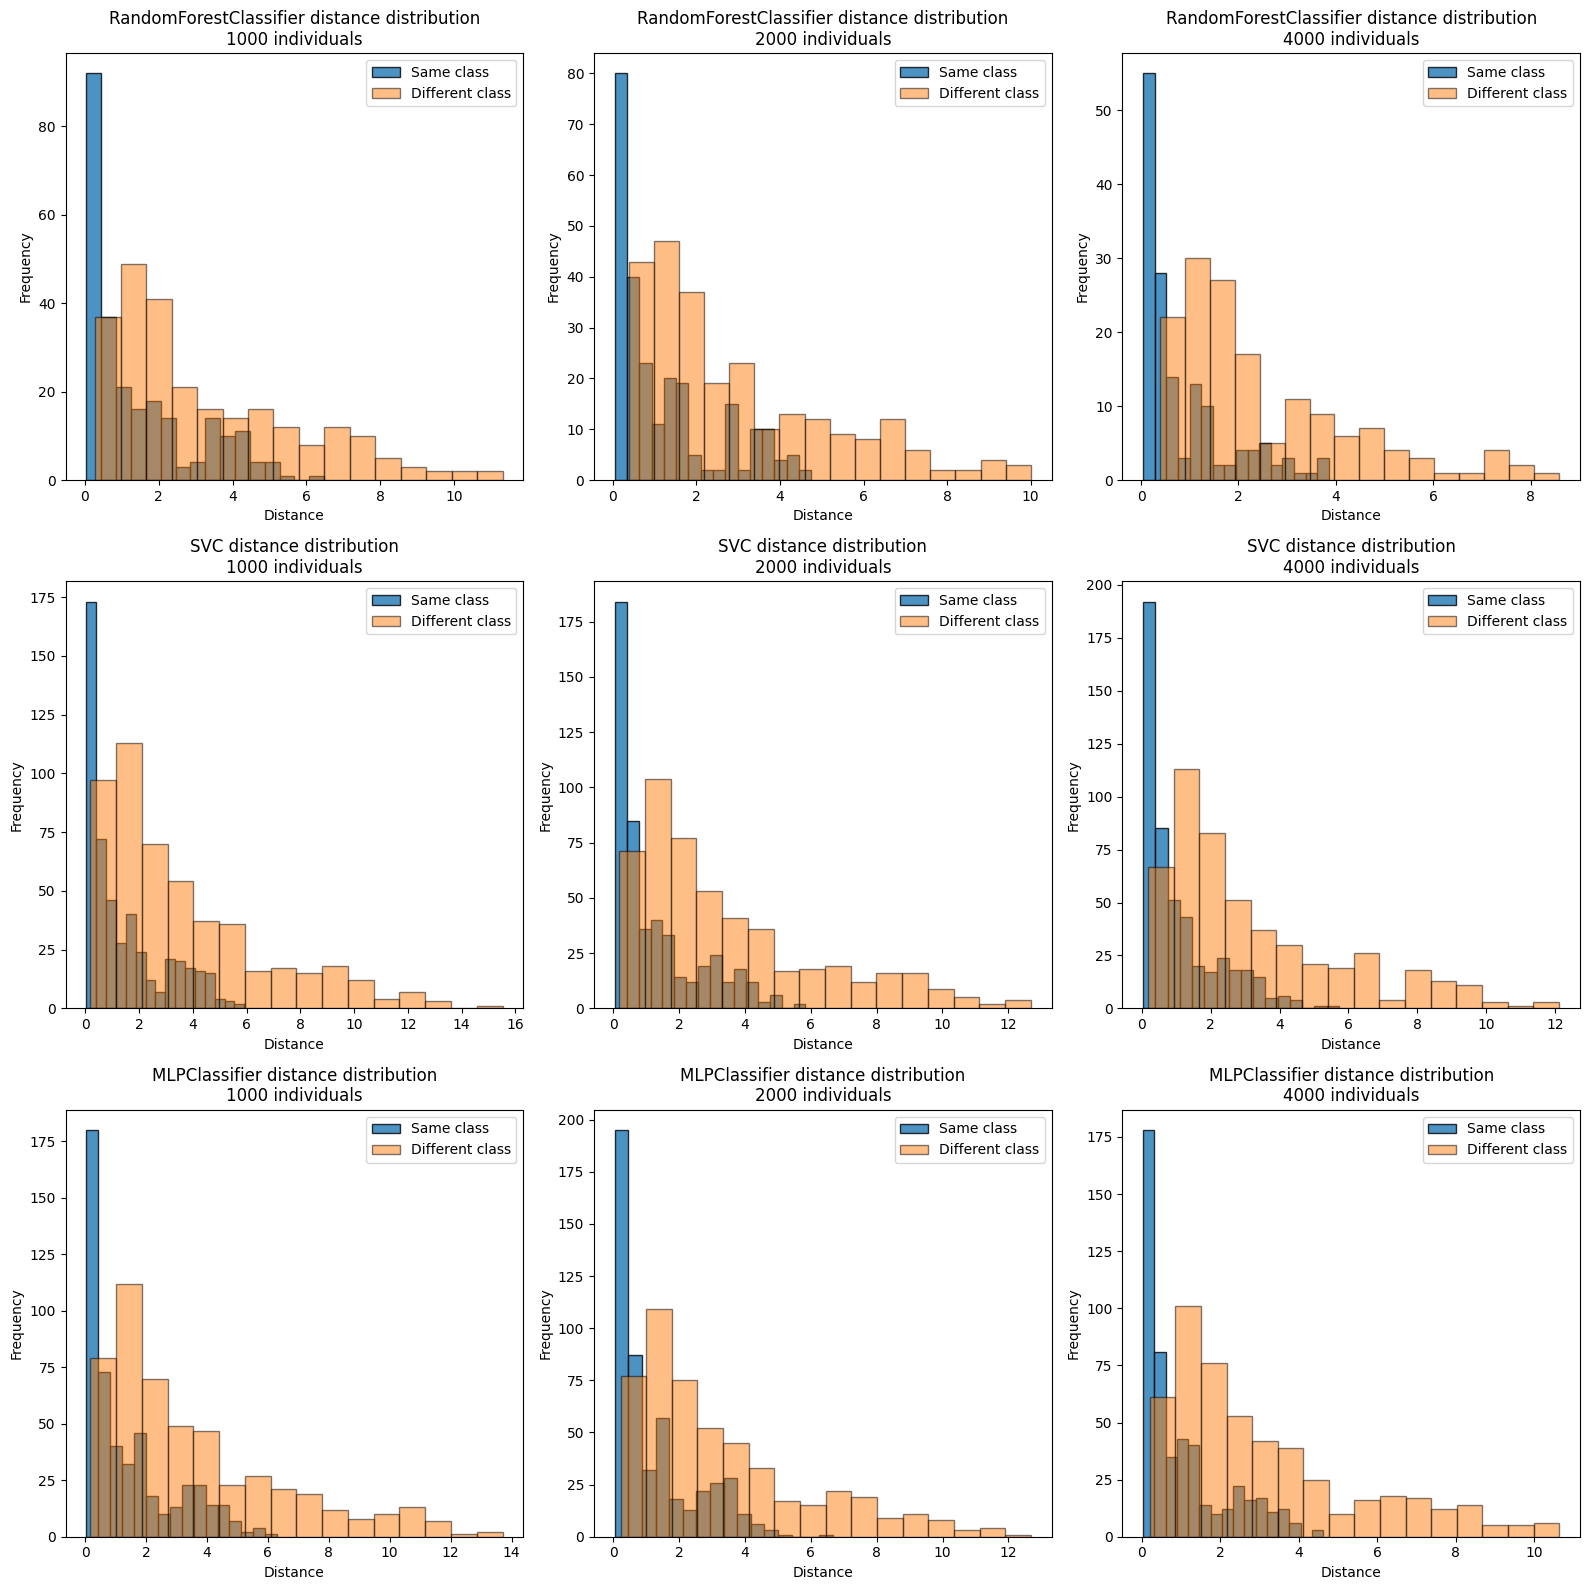

In [66]:
import matplotlib.pyplot as plt


models = df["model"].unique()
sizes = df["population_size"].unique()

fig, axes = plt.subplots(len(models), len(sizes), figsize=(16, 16))

for i, model in enumerate(models):
    for j, size in enumerate(sizes):
        same = (
            (df["model"] == model)
            & (df["class"] == df["target"])
            & (df["population_size"] == size)
        )
        diff = (
            (df["model"] == model)
            & (df["class"] != df["target"])
            & (df["population_size"] == size)
        )
        axes[i][j].set_title(f"{model} distance distribution\n{size} individuals")
        axes[i][j].set_xlabel("Distance")
        axes[i][j].set_ylabel("Frequency")

        axes[i][j].hist(
            df[same]["mean_distance"],
            bins=16,
            edgecolor="black",
            alpha=0.8,
            label="Same class",
        )
        axes[i][j].hist(
            df[diff]["mean_distance"],
            bins=16,
            edgecolor="black",
            alpha=0.5,
            label="Different class",
        )
        axes[i][j].legend()

plt.tight_layout()
plt.show()